# YOLO Object Detection Training - Google Colab

This notebook allows you to train YOLO models on Google Colab with GPU acceleration.

## Setup Instructions
1. **Enable GPU**: Go to Runtime → Change runtime type → Select GPU (T4 or better)
2. **Upload Dataset**: Upload your dataset to Google Drive or use the upload cell below
3. **Run All Cells**: Click Runtime → Run all, or run each cell sequentially

---

## Step 1: Mount Google Drive

If your dataset is stored in Google Drive, mount it here.

In [1]:
from google.colab import drive
import os
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

# ⚠️ IMPORTANT: Set your Google Drive project folder path
# Change this to your desired location in Google Drive
# Example: '/content/drive/MyDrive/YOLO_Project'
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/YOLO_Project'  # ⚠️ CHANGE THIS PATH

# Create the project directory in Drive if it doesn't exist
os.makedirs(DRIVE_PROJECT_PATH, exist_ok=True)

# Set as project root for all subsequent operations
PROJECT_ROOT = DRIVE_PROJECT_PATH

print("✅ Google Drive mounted successfully!")
print(f"📁 Project root set to: {PROJECT_ROOT}")
print(f"💾 All files will be saved to Google Drive and persist between sessions!")

Mounted at /content/drive
✅ Google Drive mounted successfully!
📁 Project root set to: /content/drive/MyDrive/YOLO_Project
💾 All files will be saved to Google Drive and persist between sessions!


## Step 2: Install Dependencies

Install all required Python packages.

In [2]:
!pip install -q ultralytics>=8.0.0 torch>=2.0.0 torchvision>=0.15.0
!pip install -q pillow>=9.0.0 opencv-python>=4.5.0 numpy>=1.21.0
!pip install -q pyyaml>=6.0 matplotlib>=3.5.0 seaborn>=0.12.0
!pip install -q scikit-learn>=1.0.0 requests>=2.28.0 tqdm>=4.64.0

print("\n✅ All dependencies installed successfully!")
print("\n📦 PyTorch version:", __import__('torch').__version__)
print("🔧 CUDA available:", __import__('torch').cuda.is_available())
if __import__('torch').cuda.is_available():
    print("🚀 GPU:", __import__('torch').cuda.get_device_name(0))


✅ All dependencies installed successfully!

📦 PyTorch version: 2.9.0+cu126
🔧 CUDA available: True
🚀 GPU: Tesla T4


## Step 3: Set Up Project Structure

Create necessary directories and set up the project.

In [3]:
import os
from pathlib import Path

# Use the Drive path set in Step 1
# PROJECT_ROOT should already be set from Step 1 (DRIVE_PROJECT_PATH)
# If not set, it will default to Drive location
if 'PROJECT_ROOT' not in globals():
    PROJECT_ROOT = '/content/drive/MyDrive/YOLO_Project'  # Default Drive location
    os.makedirs(PROJECT_ROOT, exist_ok=True)

# Change to project directory (in Google Drive)
os.chdir(PROJECT_ROOT)

# Create directory structure in Google Drive
directories = [
    "config",
    "train/images", "train/labels",
    "valid/images", "valid/labels",
    "test/images", "test/labels",
    "models",
    "results",
    "scripts"
]

for dir_path in directories:
    full_path = os.path.join(PROJECT_ROOT, dir_path)
    os.makedirs(full_path, exist_ok=True)

print(f"✅ Project structure created in Google Drive at:")
print(f"   {PROJECT_ROOT}")
print(f"📁 Current working directory: {os.getcwd()}")
print(f"💾 All files will persist in Google Drive!")

✅ Project structure created in Google Drive at:
   /content/drive/MyDrive/YOLO_Project
📁 Current working directory: /content/drive/MyDrive/YOLO_Project
💾 All files will persist in Google Drive!


## Step 4: Upload Dataset




Upload your dataset as a ZIP file, then extract it.

In [4]:
from google.colab import files
import zipfile
import os
from pathlib import Path

# Make sure we're in the Drive project directory
if 'PROJECT_ROOT' in globals():
    os.chdir(PROJECT_ROOT)
else:
    PROJECT_ROOT = '/content/drive/MyDrive/YOLO_Project'
    os.makedirs(PROJECT_ROOT, exist_ok=True)
    os.chdir(PROJECT_ROOT)

# Upload dataset ZIP file
print("📤 Please upload your dataset ZIP file...")
print("⚠️  This will be saved to Google Drive and persist between sessions!")
uploaded = files.upload()

# Extract the ZIP file directly to the Drive project directory
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        print(f"📦 Extracting {filename} to Google Drive...")
        # Extract to current directory (which is PROJECT_ROOT in Drive)
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('.')
        print(f"✅ Extracted {filename} successfully to {os.getcwd()}!")

        # Optionally, save the ZIP file to Drive for future use
        zip_drive_path = os.path.join(PROJECT_ROOT, filename)
        if os.path.exists(filename):
            import shutil
            if not os.path.exists(zip_drive_path):
                shutil.move(filename, zip_drive_path)
                print(f"💾 ZIP file also saved to Drive: {zip_drive_path}")

# Verify dataset structure
required_folders = ['train/images', 'train/labels', 'valid/images', 'valid/labels']
missing = []
for folder in required_folders:
    full_path = os.path.join(PROJECT_ROOT, folder)
    if not os.path.exists(full_path):
        missing.append(folder)

if missing:
    print(f"\n⚠️  Warning: Missing folders: {missing}")
    print("Please ensure your ZIP contains: train/images, train/labels, valid/images, valid/labels")
    print(f"Current directory: {os.getcwd()}")
else:
    print(f"\n✅ Dataset structure verified!")
    print(f"📁 Dataset saved to: {PROJECT_ROOT}")
    print(f"💾 Your dataset will persist in Google Drive!")

📤 Please upload your dataset ZIP file...
⚠️  This will be saved to Google Drive and persist between sessions!


Saving Vehicle Detection.v1i.yolov11.zip to Vehicle Detection.v1i.yolov11.zip
📦 Extracting Vehicle Detection.v1i.yolov11.zip to Google Drive...
✅ Extracted Vehicle Detection.v1i.yolov11.zip successfully to /content/drive/MyDrive/YOLO_Project!

✅ Dataset structure verified!
📁 Dataset saved to: /content/drive/MyDrive/YOLO_Project
💾 Your dataset will persist in Google Drive!


## Step 5: Create Configuration Files

Create dataset and training configuration files. **IMPORTANT**: Update the class names and number of classes to match your dataset!

In [12]:
import yaml

# Dataset configuration
# ⚠️ IMPORTANT: Update class names and number of classes to match your dataset!
dataset_config = {
    'path': '.',  # Current directory
    'train': 'train/images',
    'valid': 'valid/images',
    'test': 'test/images',
    'nc': 6,  # Number of classes - CHANGE THIS
    'names': {
        0: 'Autorickshaw',
        1: 'Bicycle',
        2: 'Bus',
        3: 'Car',
        4: 'Motorcycle',
        5: 'Truck'
    }
}

# Training configuration
training_config = {
    'model': 'yolov8n.pt',  # Pre-trained model (nano, smallest)
    'image_size': 640,
    'epochs': 30,
    'batch_size': 16,  # Adjust based on GPU memory
    'learning_rate': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 10.0,
    'translate': 0.1,
    'scale': 0.5,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.0,
    'early_stopping_patience': 5,
    'save_dir': 'results',
    'save_period': 10
}

# Save configuration files
with open('config/dataset.yaml', 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False, sort_keys=False)

with open('config/training_config.yaml', 'w') as f:
    yaml.dump(training_config, f, default_flow_style=False, sort_keys=False)

print("✅ Configuration files created!")
print("\n📝 Dataset config:")
print(f"   Classes: {dataset_config['nc']}")
print(f"   Names: {list(dataset_config['names'].values())}")
print("\n⚙️  Training config:")
print(f"   Model: {training_config['model']}")
print(f"   Epochs: {training_config['epochs']}")
print(f"   Batch Size: {training_config['batch_size']}")
print(f"   Image Size: {training_config['image_size']}")

✅ Configuration files created!

📝 Dataset config:
   Classes: 6
   Names: ['Autorickshaw', 'Bicycle', 'Bus', 'Car', 'Motorcycle', 'Truck']

⚙️  Training config:
   Model: yolov8n.pt
   Epochs: 30
   Batch Size: 16
   Image Size: 640


## Step 6: Create Training Script

Create the training script.

In [14]:
train_script = '''"""
YOLO Training Script
"""
import torch
from ultralytics import YOLO
import yaml
from pathlib import Path
import shutil


class YOLOTrainer:

    def __init__(self, config_path="config/training_config.yaml",
                 dataset_config_path="config/dataset.yaml"):
        with open(config_path, 'r') as f:
            self.config = yaml.safe_load(f)

        with open(dataset_config_path, 'r') as f:
            self.dataset_config = yaml.safe_load(f)

        self.dataset_config_path = dataset_config_path
        self.results_dir = Path(self.config.get('save_dir', 'results'))
        self.results_dir.mkdir(exist_ok=True)

    def setup_data_augmentation(self):
        return {
            'hsv_h': self.config.get('hsv_h', 0.015),
            'hsv_s': self.config.get('hsv_s', 0.7),
            'hsv_v': self.config.get('hsv_v', 0.4),
            'degrees': self.config.get('degrees', 10.0),
            'translate': self.config.get('translate', 0.1),
            'scale': self.config.get('scale', 0.5),
            'flipud': self.config.get('flipud', 0.0),
            'fliplr': self.config.get('fliplr', 0.5),
            'mosaic': self.config.get('mosaic', 1.0),
            'mixup': self.config.get('mixup', 0.0),
        }

    def train(self):
        print("=" * 60)
        print("YOLO Training Configuration")
        print("=" * 60)
        print(f"Model: {self.config['model']}")
        print(f"Image Size: {self.config['image_size']}")
        print(f"Epochs: {self.config['epochs']}")
        print(f"Batch Size: {self.config['batch_size']}")
        print(f"Learning Rate: {self.config['learning_rate']}")
        print(f"Dataset: {self.dataset_config['path']}")
        print(f"Classes: {self.dataset_config['nc']}")
        print("=" * 60)

        # Initialize model
        model = YOLO(self.config['model'])

        # Get augmentation config
        augment_config = self.setup_data_augmentation()

        # Train model
        results = model.train(
            data=self.dataset_config_path,
            epochs=self.config['epochs'],
            imgsz=self.config['image_size'],
            batch=self.config['batch_size'],
            lr0=self.config['learning_rate'],
            momentum=self.config.get('momentum', 0.937),
            weight_decay=self.config.get('weight_decay', 0.0005),
            hsv_h=augment_config['hsv_h'],
            hsv_s=augment_config['hsv_s'],
            hsv_v=augment_config['hsv_v'],
            degrees=augment_config['degrees'],
            translate=augment_config['translate'],
            scale=augment_config['scale'],
            flipud=augment_config['flipud'],
            fliplr=augment_config['fliplr'],
            mosaic=augment_config['mosaic'],
            mixup=augment_config['mixup'],
            project=str(self.results_dir),
            name='train',
            save=True,
            save_period=self.config.get('save_period', 10),
            val=True,
            plots=True,
            patience=self.config.get('early_stopping_patience', 5),
        )

        # Save best model
        best_model_path = results.save_dir / 'weights' / 'best.pt'
        if best_model_path.exists():
            models_dir = Path('models')
            models_dir.mkdir(exist_ok=True)
            shutil.copy(best_model_path, models_dir / 'best_model.pt')
            print(f"\n✅ Best model saved to: {models_dir / 'best_model.pt'}")

        print("\n🎉 Training completed!")
        return results


if __name__ == "__main__":
    trainer = YOLOTrainer()
    trainer.train()
'''

with open('scripts/train.py', 'w') as f:
    f.write(train_script)

# Create __init__.py for scripts package
Path('scripts/__init__.py').touch()

print("✅ Training script created!")

✅ Training script created!


## Step 7: Verify Dataset

Check that your dataset is properly structured.

In [15]:
import os
from pathlib import Path

def count_files(directory):
    if os.path.exists(directory):
        return len(list(Path(directory).glob('*')))
    return 0

print("📊 Dataset Statistics:")
print("=" * 50)
print(f"Train Images: {count_files('train/images')}")
print(f"Train Labels: {count_files('train/labels')}")
print(f"Valid Images:   {count_files('valid/images')}")
print(f"Valid Labels:   {count_files('valid/labels')}")
print(f"Test Images:  {count_files('test/images')}")
print(f"Test Labels:  {count_files('test/labels')}")
print("=" * 50)

# Verify label format
if count_files('train/labels') > 0:
    sample_label = list(Path('train/labels').glob('*.txt'))[0]
    with open(sample_label, 'r') as f:
        content = f.read().strip()
        print(f"\n📝 Sample label file ({sample_label.name}):")
        if content:
            lines = content.split('\n')[:3]  # Show first 3 lines
            for line in lines:
                print(f"   {line}")
        else:
            print("   (empty file)")

print("\n✅ Dataset verification complete!")

📊 Dataset Statistics:
Train Images: 1789
Train Labels: 1789
Valid Images:   235
Valid Labels:   235
Test Images:  52
Test Labels:  52

📝 Sample label file (100_jpg.rf.d437711ddd3755a76e41b78531a7f1cd.txt):
   3 0.51015625 0.02890625 0.1015625 0.053125
   3 0.93828125 0.03046875 0.1125 0.05625
   3 0.9609375 0.15078125 0.075 0.096875

✅ Dataset verification complete!


## Step 8: Train the Model

🚀 **Start training!** This may take 30 minutes to several hours depending on your dataset size and epochs.

In [17]:
import sys
sys.path.append('scripts')

from train import YOLOTrainer

# Initialize and train
trainer = YOLOTrainer(
    config_path='config/training_config.yaml',
    dataset_config_path='config/dataset.yaml'
)

results = trainer.train()

YOLO Training Configuration
Model: yolov8n.pt
Image Size: 640
Epochs: 30
Batch Size: 16
Learning Rate: 0.01
Dataset: .
Classes: 6
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config/dataset.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, 

## Step 9: View Training Results

Display training plots and metrics.


📊 confusion_matrix.png


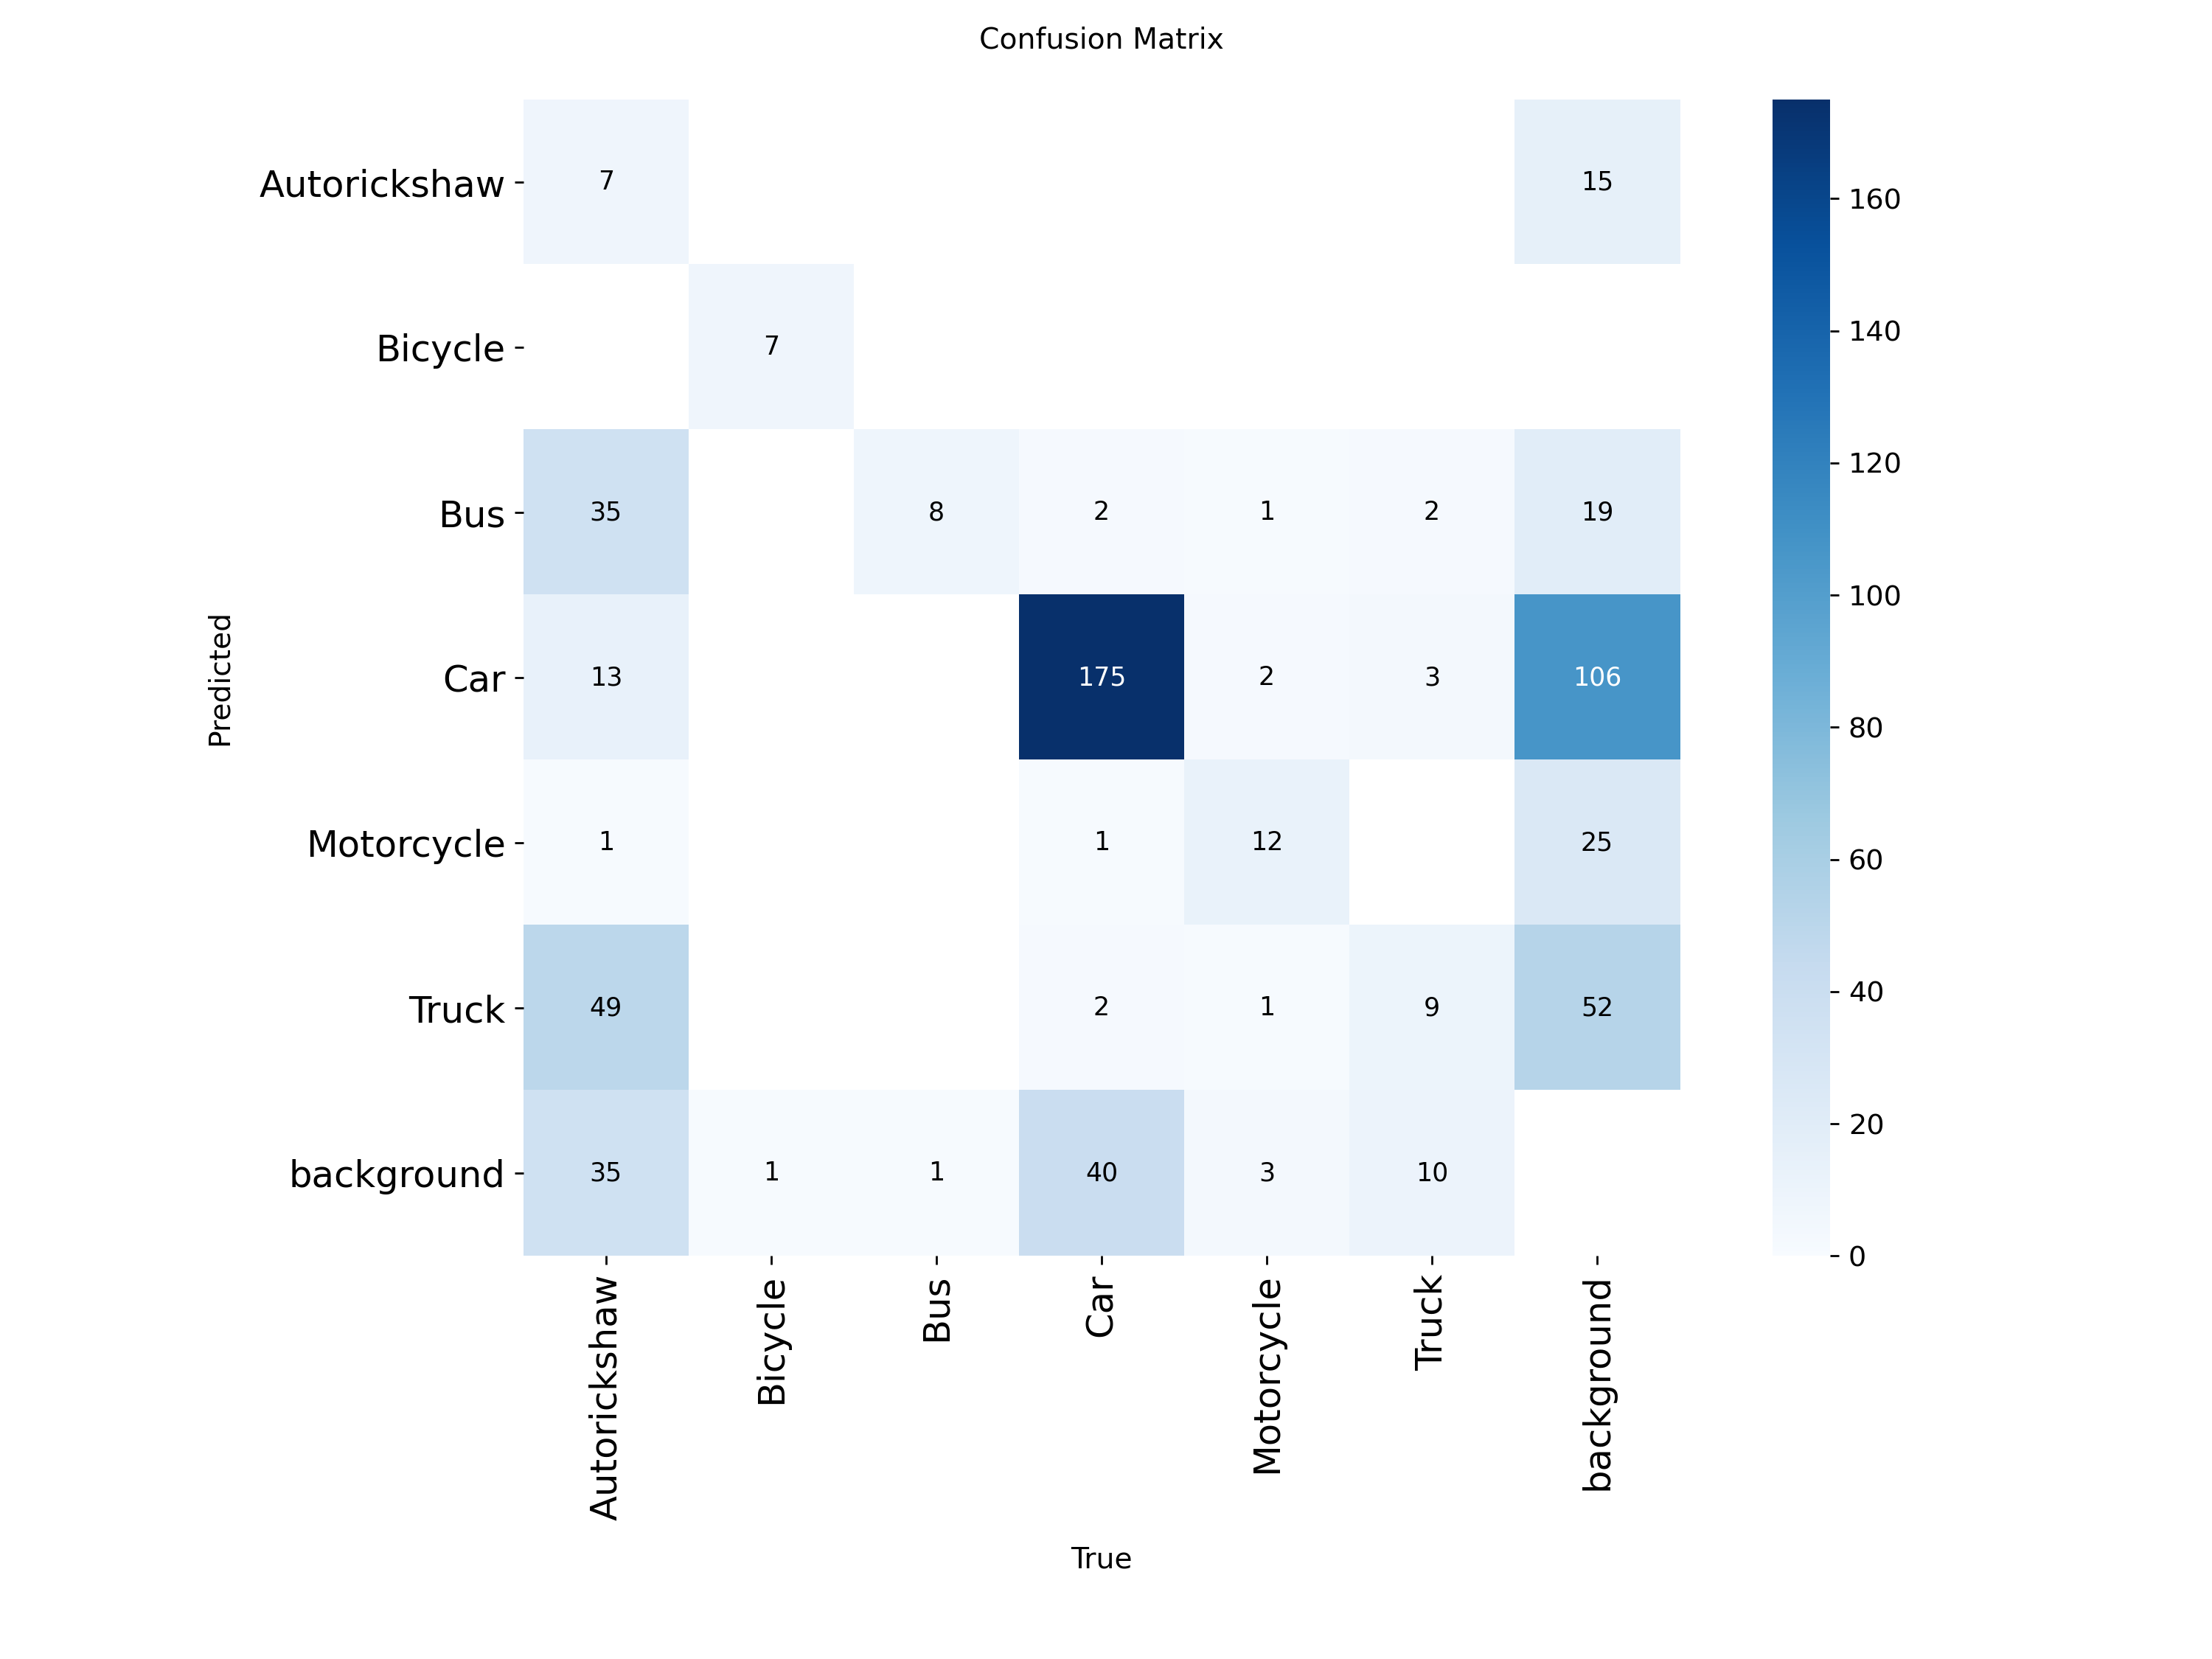


📊 BoxF1_curve.png


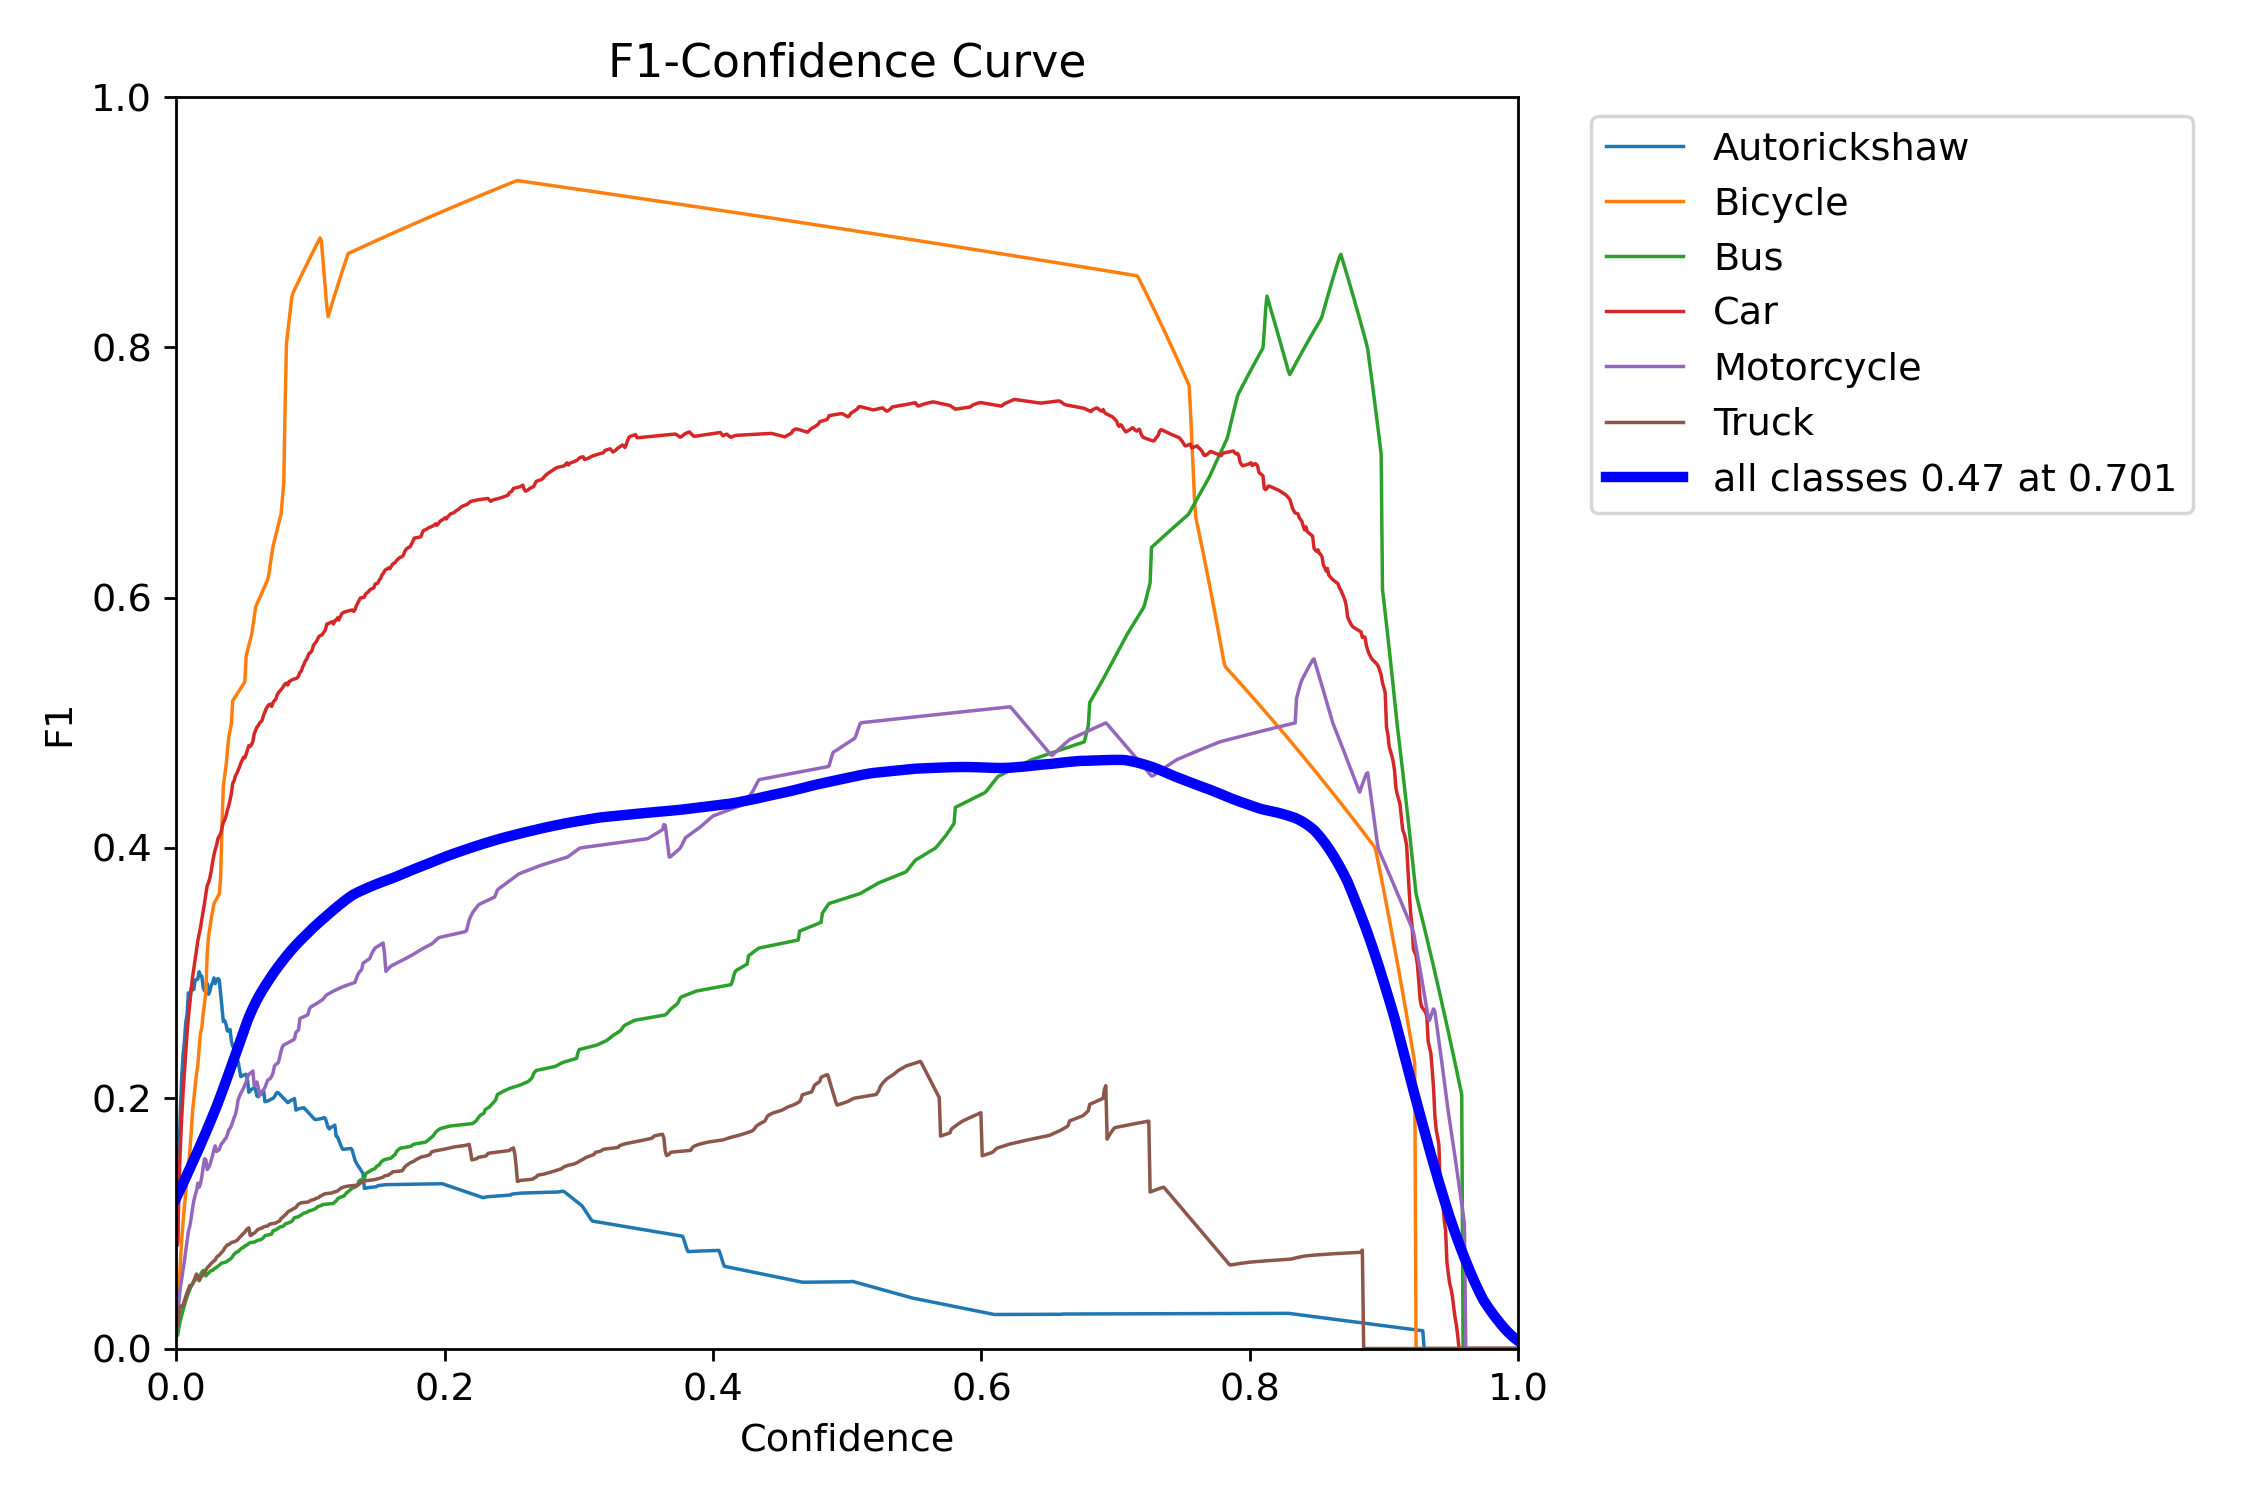


📊 BoxPR_curve.png


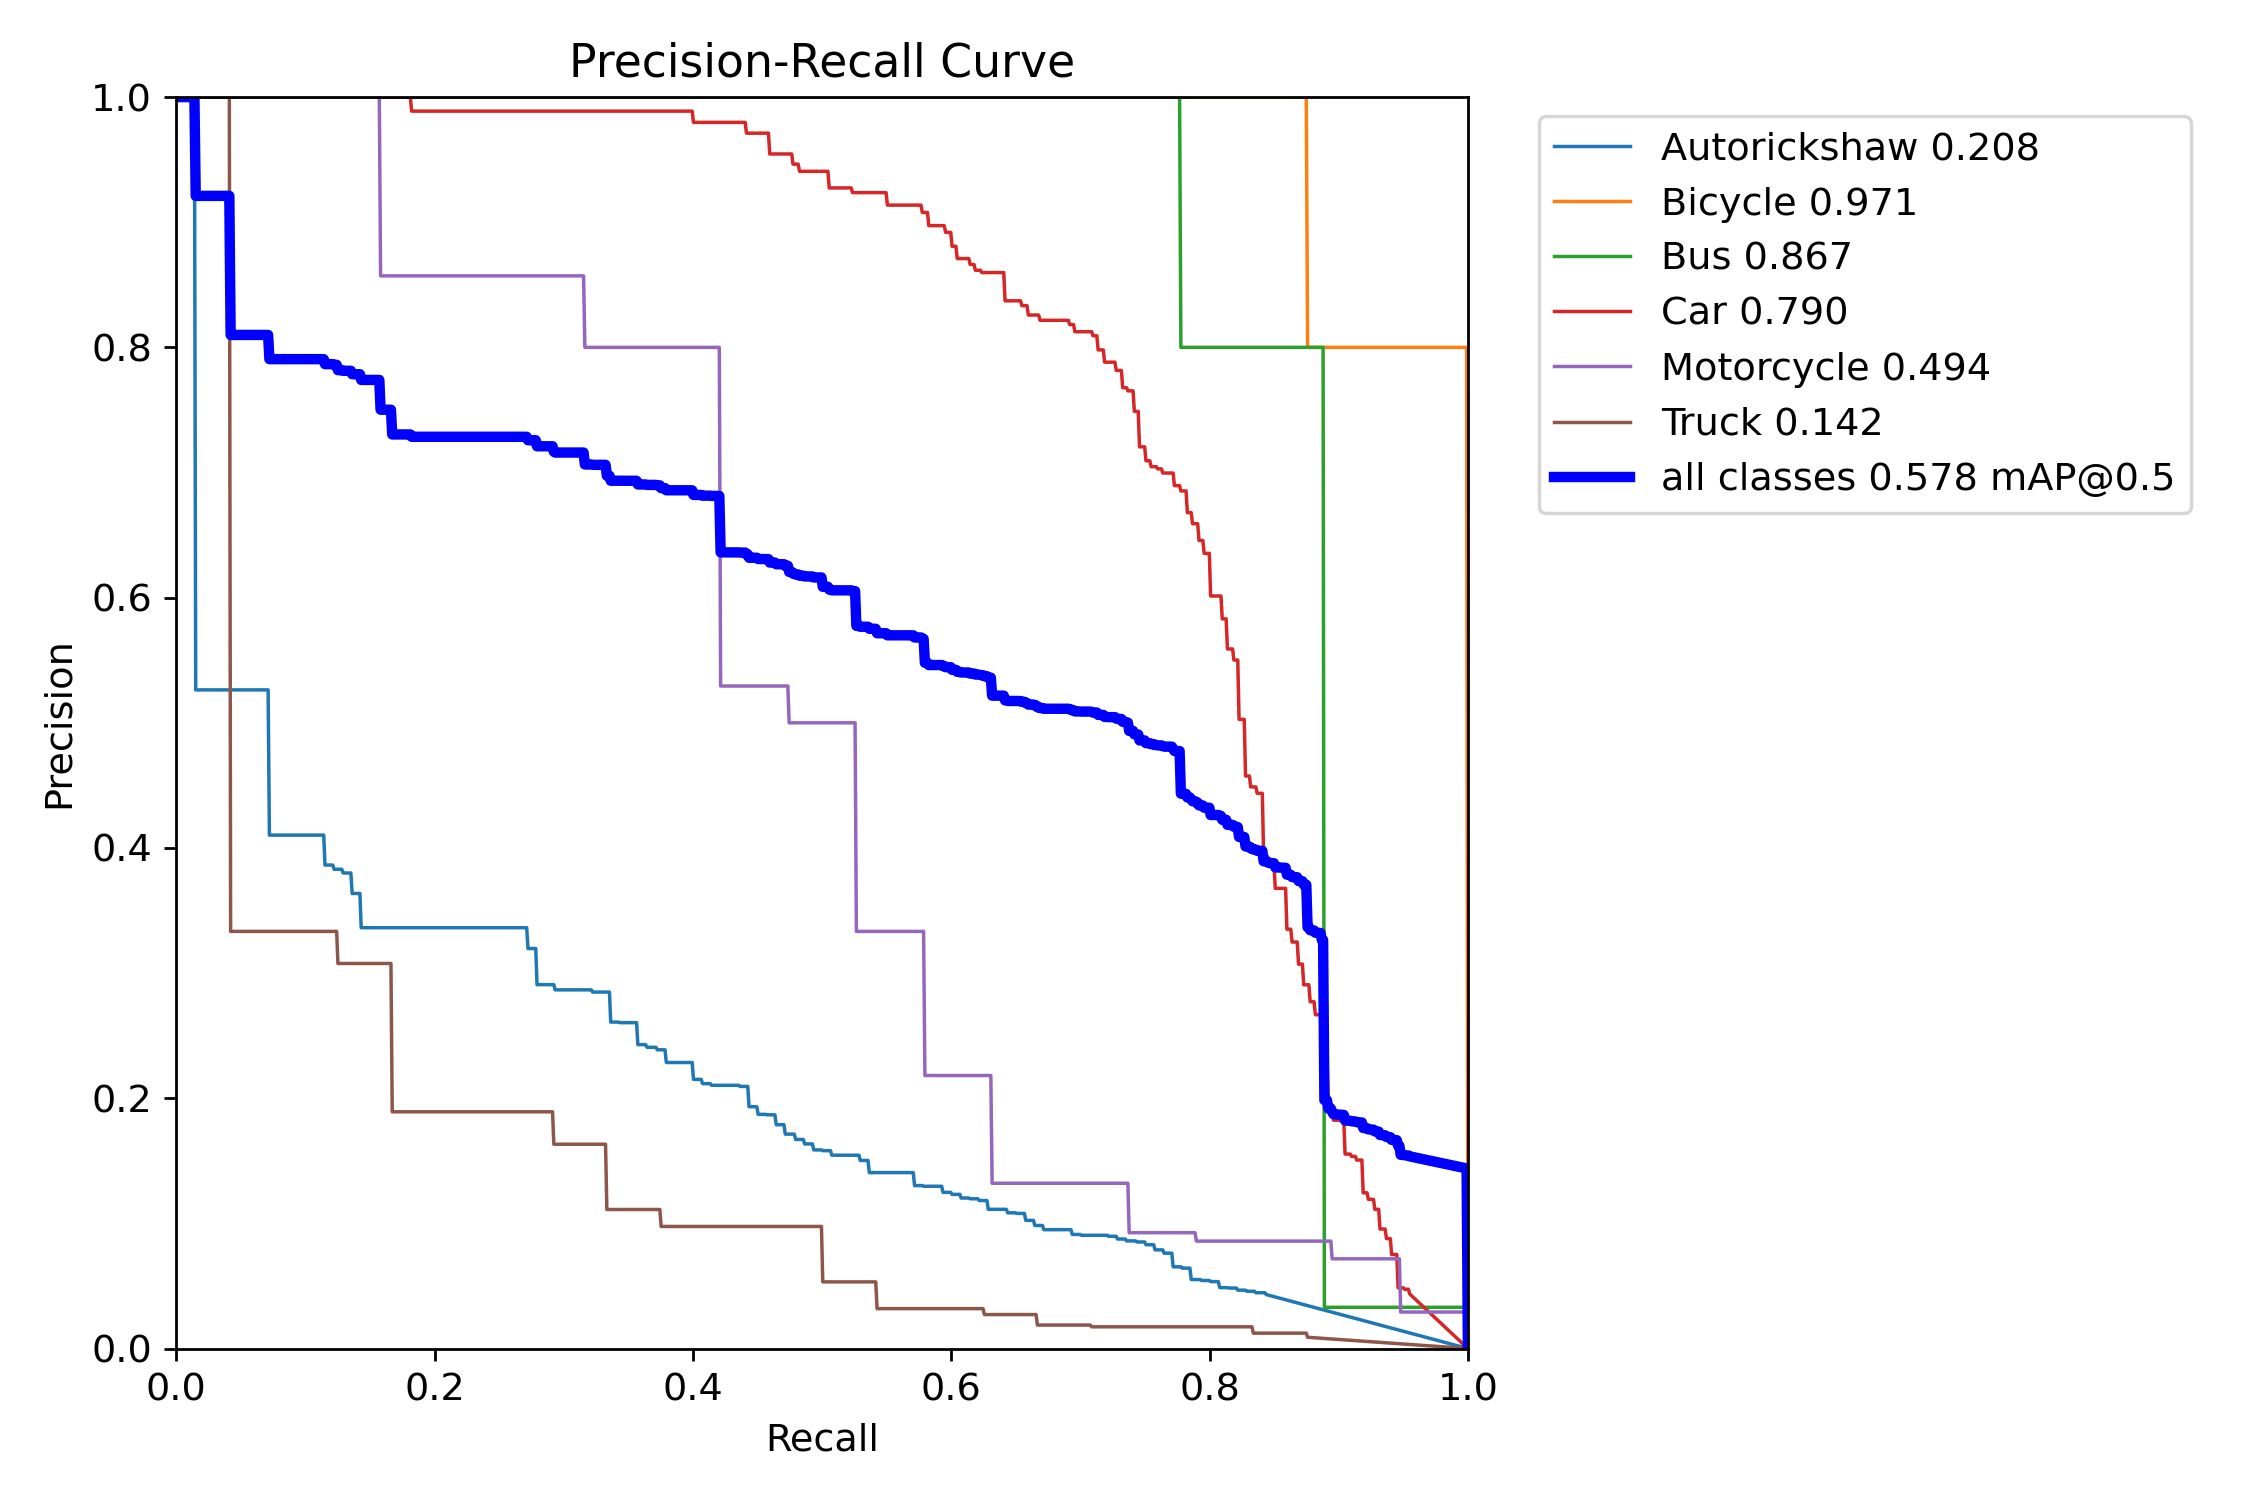


📊 BoxP_curve.png


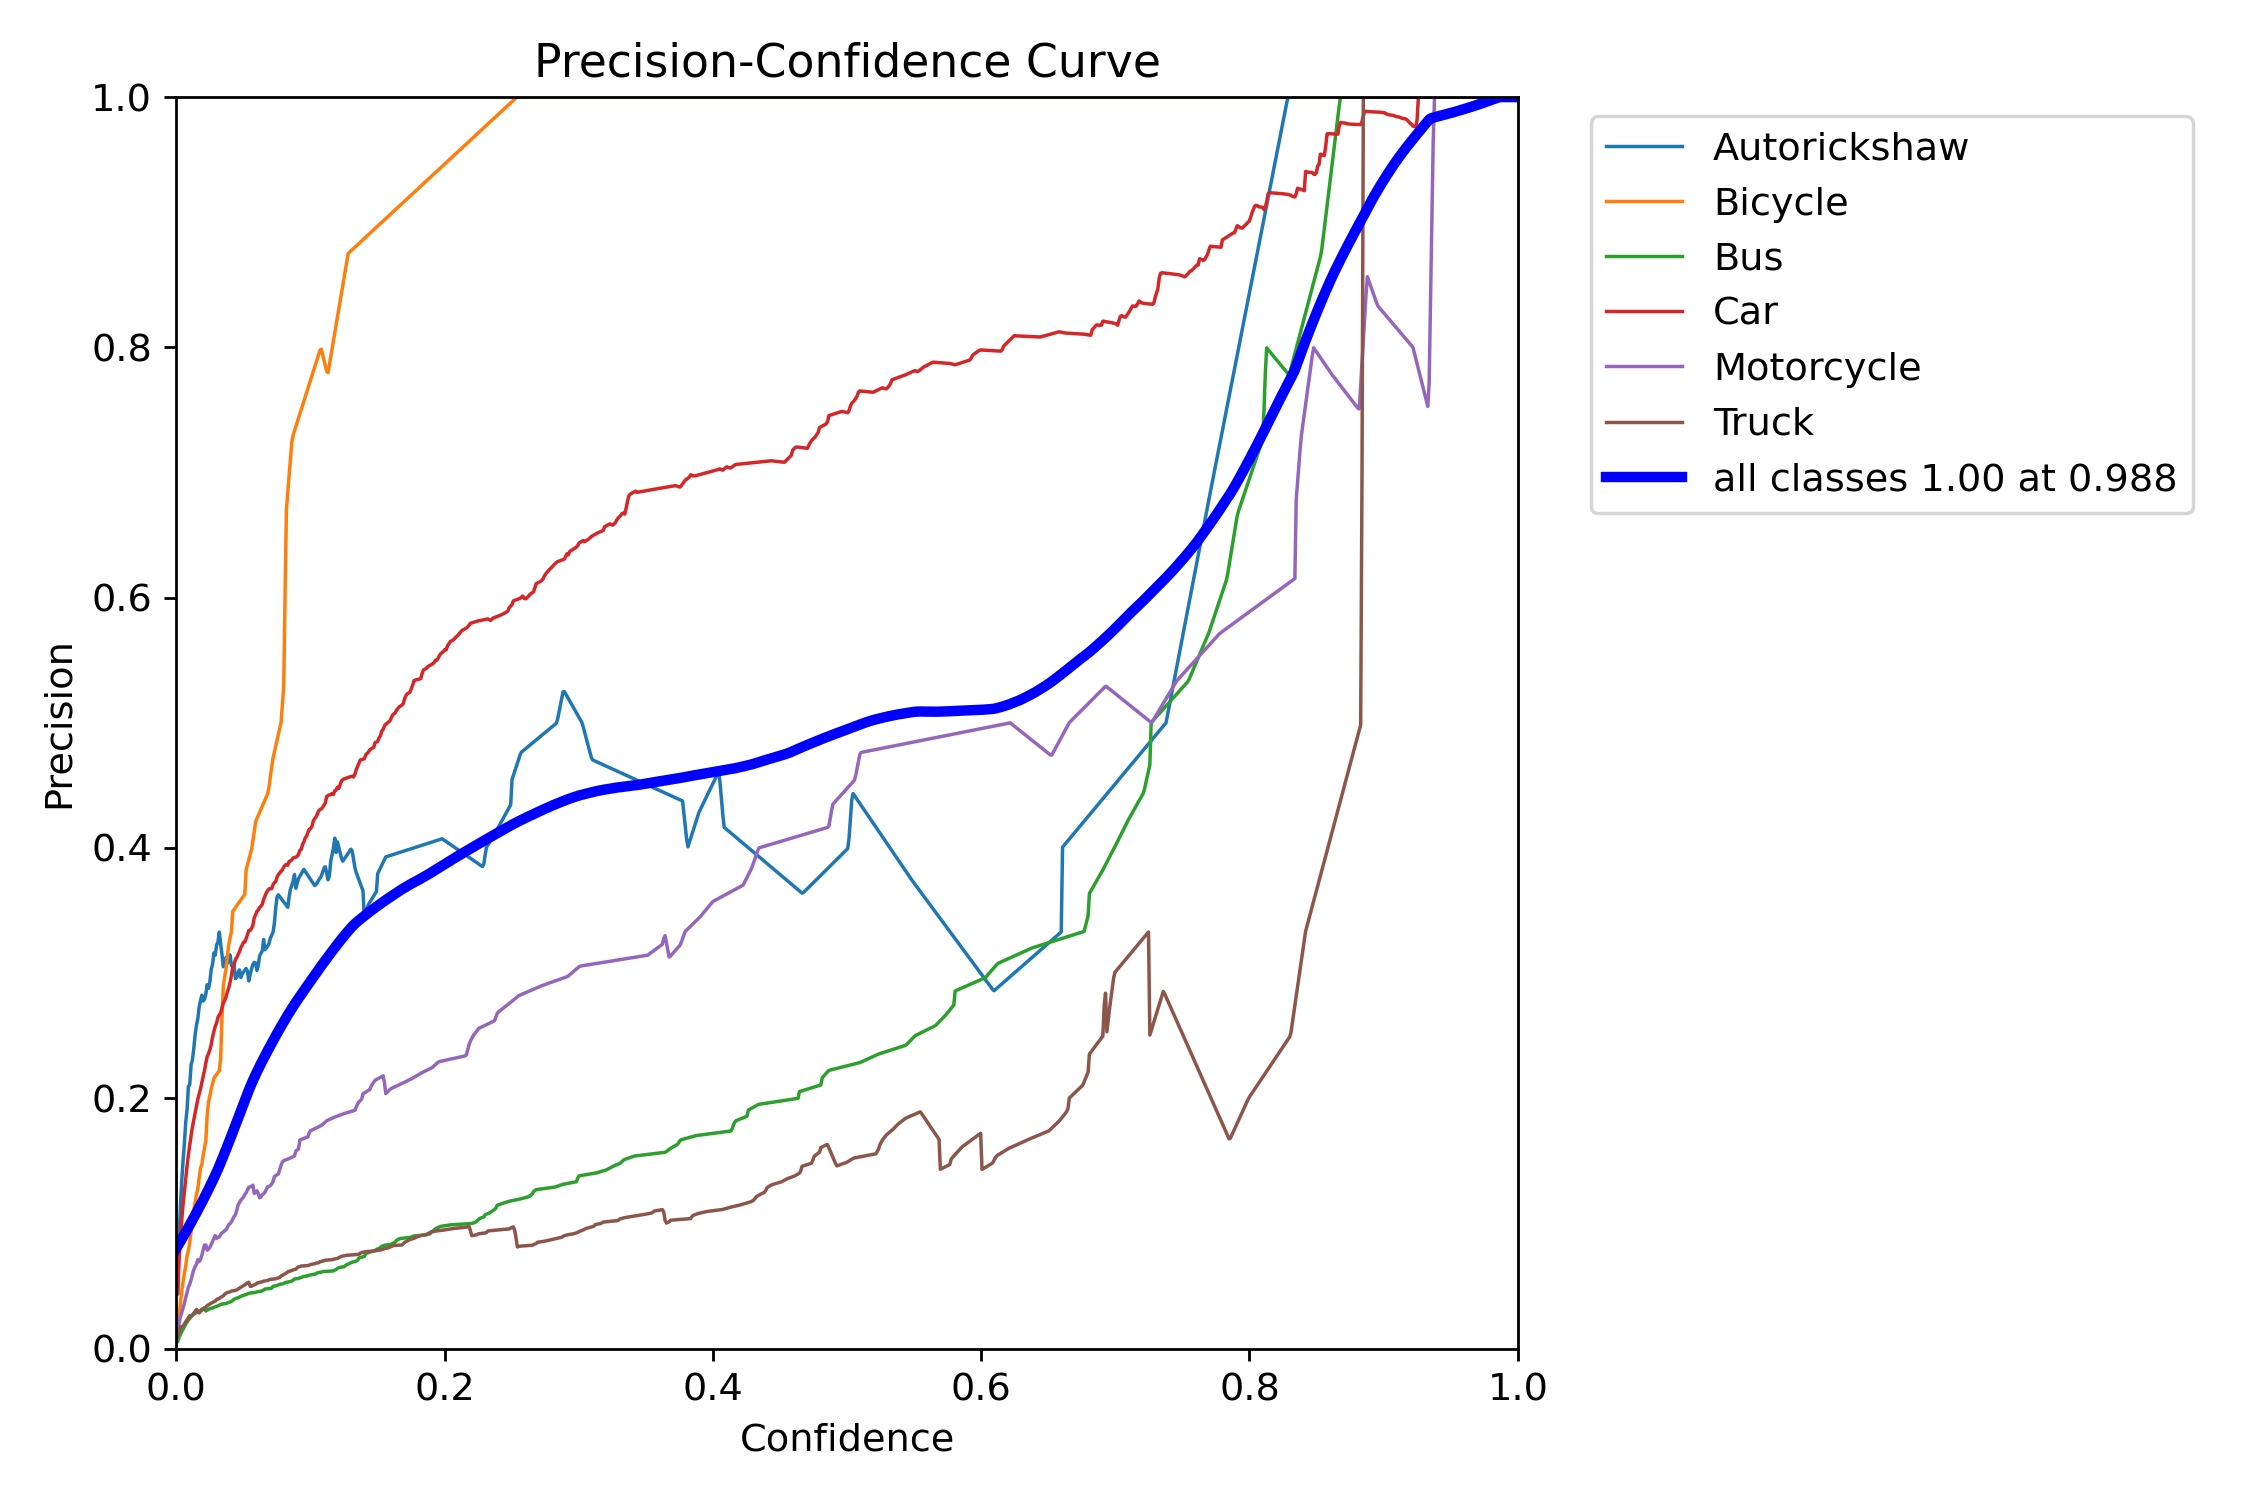


📊 BoxR_curve.png


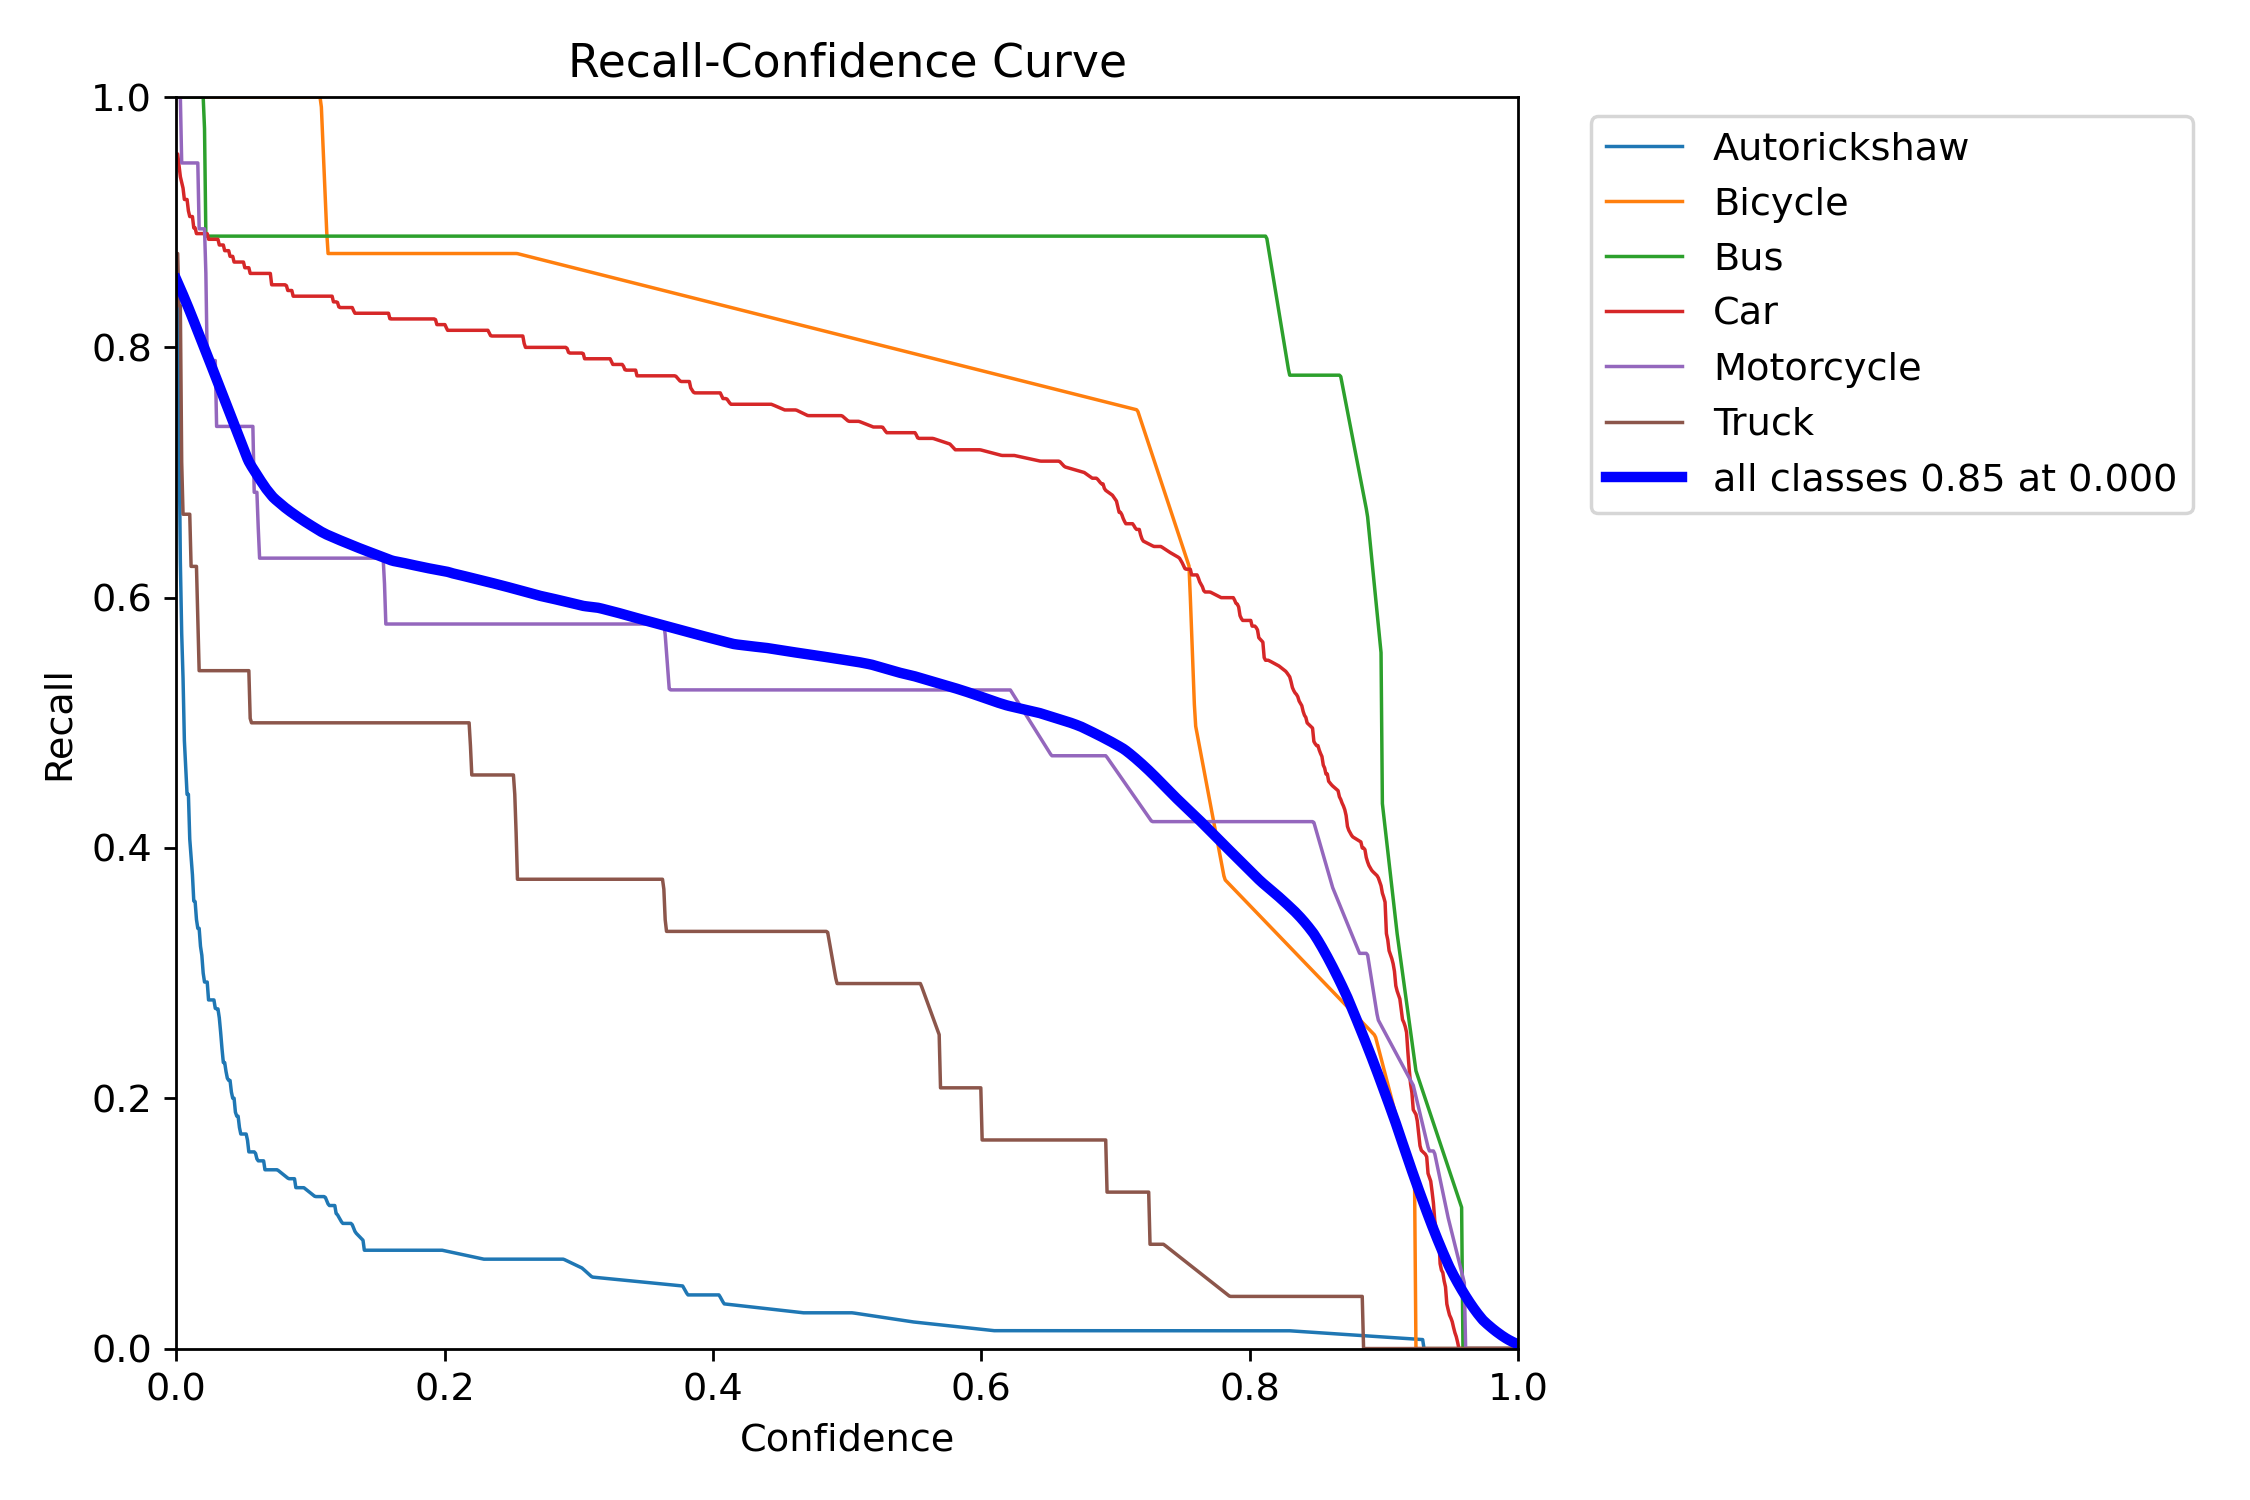


✅ Best model saved: models/best_model.pt (5.96 MB)


In [21]:
from IPython.display import Image, display
from pathlib import Path

results_dir = Path('results/train4')

# Display training results
result_images = [

    'confusion_matrix.png',
    'BoxF1_curve.png',
    'BoxPR_curve.png',
    'BoxP_curve.png',
    'BoxR_curve.png'
]

for img_name in result_images:
    img_path = results_dir / img_name
    if img_path.exists():
        print(f"\n📊 {img_name}")
        display(Image(str(img_path)))
    else:
        print(f"⚠️  {img_name} not found")

# Check for best model
best_model = Path('models/best_model.pt')
if best_model.exists():
    size_mb = best_model.stat().st_size / (1024 * 1024)
    print(f"\n✅ Best model saved: {best_model} ({size_mb:.2f} MB)")
else:
    print("\n⚠️  Best model not found in models/ directory")

## Testing the trained model on a sample image.



🔍 Running inference on: Autorickshaw-102-_jpg.rf.c9f10da100747d86eee429658bd47270.jpg

image 1/1 /content/drive/MyDrive/YOLO_Project/test/images/Autorickshaw-102-_jpg.rf.c9f10da100747d86eee429658bd47270.jpg: 640x640 1 Bus, 1 Car, 1 Truck, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/YOLO_Project/runs/detect/predict


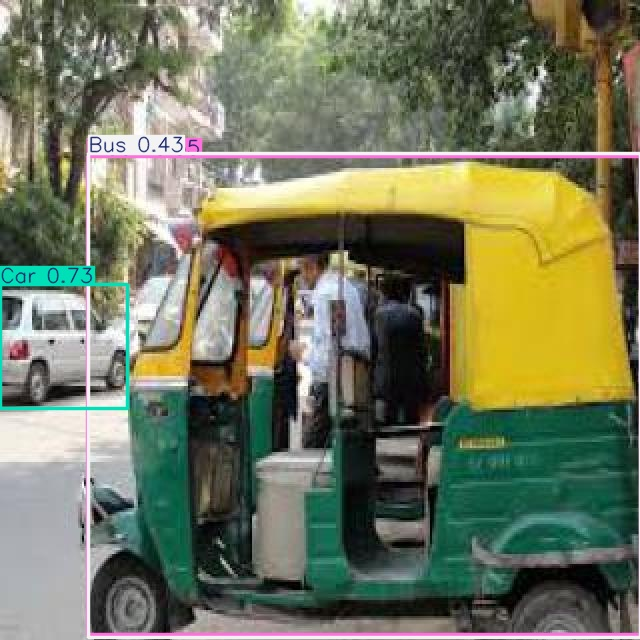

✅ Result saved to: runs/detect/predict/Autorickshaw-102-_jpg.rf.c9f10da100747d86eee429658bd47270.jpg


In [22]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display

# Load trained model
model_path = 'models/best_model.pt'
if not Path(model_path).exists():
    # Try alternative location
    model_path = 'results/train/weights/best.pt'

if Path(model_path).exists():
    model = YOLO(model_path)

    # Test on a sample image
    test_images = list(Path('test/images').glob('*.jpg')) + list(Path('test/images').glob('*.png'))

    if test_images:
        sample_image = test_images[0]
        print(f"🔍 Running inference on: {sample_image.name}")

        # Run prediction
        results = model.predict(source=str(sample_image), save=True, conf=0.25)

        # Display result
        output_path = Path('runs/detect/predict') / sample_image.name
        if output_path.exists():
            display(Image(str(output_path)))
            print(f"✅ Result saved to: {output_path}")
    else:
        print("⚠️  No test images found")
else:
    print(f"⚠️  Model not found at {model_path}")

In [ ]:
Push

In [28]:
# FIRST: Reset everything and start fresh
import os
import shutil

# Remove any existing .git folder
if os.path.exists('/content/drive/MyDrive/YOLO_Project/.git'):
    shutil.rmtree('/content/drive/MyDrive/YOLO_Project/.git')
    print("Removed old .git folder")

# Navigate to project
os.chdir('/content/drive/MyDrive/YOLO_Project')

# Clone fresh
!git clone https://github.com/hailer-MIT/ObjectDetection-with-YOLO.git /content/temp_clone

# Copy everything from temp_clone to your project
!cp -r /content/temp_clone/.git /content/drive/MyDrive/YOLO_Project/

print("✅ Repository linked successfully!")

Removed old .git folder
Cloning into '/content/temp_clone'...
✅ Repository linked successfully!


In [30]:
"""
Complete cell code to push project to GitHub directly from Colab
Add this as a new cell at the end of your notebook
"""

# ============================================
# PUSH TO GITHUB FROM COLAB - All-in-One (FIXED)
# ============================================

import os
import getpass
import subprocess

# Make sure we're in Drive directory
if 'PROJECT_ROOT' in globals():
    os.chdir(PROJECT_ROOT)
else:
    PROJECT_ROOT = '/content/drive/MyDrive/YOLO_Project'
    os.chdir(PROJECT_ROOT)

print(f"📁 Current directory: {os.getcwd()}\n")

# ============================================
# STEP 1: Install Git
# ============================================
print("📦 Step 1: Installing git...")
!apt-get -qq update > /dev/null 2>&1
!apt-get -qq install -y git > /dev/null 2>&1
!git --version
print("✅ Git installed\n")

# ============================================
# STEP 2: Configure Git
# ============================================
print("⚙️  Step 2: Configuring git...")
GITHUB_USERNAME = "hailer-MIT"  # CHANGE THIS
GITHUB_EMAIL = "hailomasegede@gmail.com"  # CHANGE THIS

!git config --global user.name "{GITHUB_USERNAME}"
!git config --global user.email "{GITHUB_EMAIL}"
print(f"✅ Git configured: {GITHUB_USERNAME} <{GITHUB_EMAIL}>\n")

# ============================================
# STEP 3: Initialize Git Repository
# ============================================
print("📂 Step 3: Initializing git repository...")
if not os.path.exists('.git'):
    !git init
    print("✅ Git repository initialized")
else:
    print("✅ Git repository already exists")

# ============================================
# STEP 4: Create .gitignore (if not exists)
# ============================================
print("\n📝 Step 4: Setting up .gitignore...")
gitignore_content = """# Python
__pycache__/
*.py[cod]
*$py.class
*.so
.Python
env/
venv/
ENV/

# Dataset (usually too large for GitHub)
train/
val/
test/
*.zip

# Large model files
*.pt
*.pth
*.weights
*.onnx

# IDE
.vscode/
.idea/
*.swp
*.swo

# OS
.DS_Store
Thumbs.db

# Colab
.ipynb_checkpoints/
.drive/

# Cache
*.cache
.cache/
.pytest_cache/

# Logs
*.log
logs/

# Temporary files
*.tmp
temp/
tmp/
"""

if not os.path.exists('.gitignore'):
    with open('.gitignore', 'w') as f:
        f.write(gitignore_content)
    !git add .gitignore
    !git commit -m "Add .gitignore"
    print("✅ .gitignore created and committed")
else:
    print("✅ .gitignore already exists")

# ============================================
# STEP 5: Add and Commit Files
# ============================================
print("\n📦 Step 5: Adding files to git...")
!git add .
print("✅ Files added")

print("\n💾 Step 6: Committing changes...")
result = subprocess.run(['git', 'commit', '-m', 'Update: YOLO training project with results'],
                       capture_output=True, text=True)
if result.returncode == 0:
    print("✅ Changes committed")
elif "nothing to commit" in result.stderr:
    print("ℹ️  No changes to commit (everything up to date)")
else:
    print(f"⚠️  Commit error: {result.stderr}")
    # Try force commit if there are merge issues
    !git commit -m "Update: YOLO training project" --allow-empty

# ============================================
# STEP 7: PUSH TO GITHUB (FIXED AUTHENTICATION)
# ============================================
print("\n" + "="*60)
print("🚀 PUSHING TO GITHUB")
print("="*60)

# OPTION 1: Create NEW repository (if doesn't exist)
# OPTION 2: Use existing repository

# Your repository URL
GITHUB_REPO_URL = "https://github.com/hailer-MIT/ObjectDetection-with-YOLO.git"

print(f"\n📦 Target repository: {GITHUB_REPO_URL}")

# ============================================
# SOLUTION 1: Try with Personal Access Token
# ============================================
print("\n1️⃣  METHOD 1: Using Personal Access Token")

# Get token securely
print("\n🔐 Get your GitHub Personal Access Token from:")
print("   https://github.com/settings/tokens")
print("\n💡 Make sure it has 'repo' permissions (full control)")
print("💡 If old token failed, generate a NEW one")

GITHUB_TOKEN = getpass.getpass("\nPaste your GitHub PAT: ")

# Remove old remote
!git remote remove origin 2>/dev/null || true

# METHOD A: Embed token in URL (for HTTPS)
print("\n🔄 Trying with token embedded in URL...")
repo_with_token = GITHUB_REPO_URL.replace('https://', f'https://{GITHUB_TOKEN}@')
!git remote add origin {repo_with_token}

# Rename branch to main
!git branch -M main

# Try to push
print("\n📤 Pushing to GitHub...")
push_result = subprocess.run(['git', 'push', '-u', 'origin', 'main'],
                            capture_output=True, text=True)

if push_result.returncode == 0:
    print("✅ SUCCESS! Code pushed to GitHub!")
    print(f"🔗 Check: https://github.com/hailer-MIT/ObjectDetection-with-YOLO")
else:
    print(f"❌ Push failed with token method")
    print(f"Error: {push_result.stderr}")

    # ============================================
    # SOLUTION 2: Check if repo exists, create if not
    # ============================================
    print("\n2️⃣  METHOD 2: Check/Create Repository")

    import requests

    # Check if repo exists
    print(f"\n🔍 Checking if repository exists...")
    response = requests.get(f"https://api.github.com/repos/hailer-MIT/ObjectDetection-with-YOLO",
                           headers={"Authorization": f"token {GITHUB_TOKEN}"})

    if response.status_code == 404:
        print("❌ Repository doesn't exist! Creating new one...")

        # Create new repository
        create_data = {
            "name": "ObjectDetection-with-YOLO",
            "description": "YOLO Object Detection Training Project",
            "private": False,
            "auto_init": False
        }

        create_response = requests.post("https://api.github.com/user/repos",
                                       headers={"Authorization": f"token {GITHUB_TOKEN}"},
                                       json=create_data)

        if create_response.status_code in [200, 201]:
            print("✅ Repository created successfully!")
            print("🔄 Try pushing again...")
            !git push -u origin main
        else:
            print(f"❌ Failed to create repository: {create_response.text}")

    elif response.status_code == 200:
        print("✅ Repository exists, but permission issue")
        print("\n🔧 Possible solutions:")
        print("1. Generate NEW Personal Access Token")
        print("2. Make sure token has 'repo' scope")
        print("3. Try SSH method below")

        # ============================================
        # SOLUTION 3: Try SSH Method
        # ============================================
        print("\n3️⃣  METHOD 3: Try SSH (if you have SSH key setup)")

        # Change to SSH URL
        ssh_url = "git@github.com:hailer-MIT/ObjectDetection-with-YOLO.git"
        print(f"\n🔄 Switching to SSH URL: {ssh_url}")
        !git remote set-url origin {ssh_url}

        # Try SSH push
        print("📤 Trying SSH push...")
        !git push -u origin main

    else:
        print(f"⚠️  API Error: {response.status_code} - {response.text}")

# ============================================
# STEP 8: Verification
# ============================================
print("\n" + "="*60)
print("✅ GIT STATUS")
print("="*60)
!git status

print("\n" + "="*60)
print("📊 GIT LOG")
print("="*60)
!git log --oneline -5

print("\n" + "="*60)
print("🔗 REMOTE INFO")
print("="*60)
!git remote -v

📁 Current directory: /content/drive/MyDrive/YOLO_Project

📦 Step 1: Installing git...
git version 2.34.1
✅ Git installed

⚙️  Step 2: Configuring git...
✅ Git configured: hailer-MIT <hailomasegede@gmail.com>

📂 Step 3: Initializing git repository...
✅ Git repository already exists

📝 Step 4: Setting up .gitignore...
✅ .gitignore already exists

📦 Step 5: Adding files to git...
✅ Files added

💾 Step 6: Committing changes...
⚠️  Commit error: 
[main 2e8bd4c] Update: YOLO training project

🚀 PUSHING TO GITHUB

📦 Target repository: https://github.com/hailer-MIT/ObjectDetection-with-YOLO.git

1️⃣  METHOD 1: Using Personal Access Token

🔐 Get your GitHub Personal Access Token from:
   https://github.com/settings/tokens

💡 Make sure it has 'repo' permissions (full control)
💡 If old token failed, generate a NEW one

Paste your GitHub PAT: ··········

🔄 Trying with token embedded in URL...

📤 Pushing to GitHub...
✅ SUCCESS! Code pushed to GitHub!
🔗 Check: https://github.com/hailer-MIT/ObjectDet

In [38]:
import os
import shutil

# Set destination folder
if 'PROJECT_ROOT' in globals():
    drive_folder = PROJECT_ROOT
else:
    drive_folder = '/content/drive/MyDrive/YOLO_Project'

# Current notebook file name (change if different)
notebook_name = 'YOLO_Training_Colab.ipynb'

# Copy from Colab to Drive
source = f'/content/{notebook_name}'
destination = os.path.join(drive_folder, notebook_name)

if os.path.exists(source):
    shutil.copy(source, destination)
    print(f"✅ Notebook saved to: {destination}")
else:
    print(f"❌ Notebook not found at: {source}")
    print("\nTrying to download current notebook...")

    # Alternative: Download and save
    from google.colab import files
    files.download(notebook_name)
    print("✅ Download started. Then upload it to your Drive folder manually.")

❌ Notebook not found at: /content/YOLO_Training_Colab2.ipynb

Trying to download current notebook...


FileNotFoundError: Cannot find file: YOLO_Training_Colab2.ipynb

In [34]:
os.getcwd()

'/content/drive/MyDrive/YOLO_Project'